This script created a test case for mosquito simulation using FEniCSX.

The Neches River fort.64.nc are used to determine which node has abs(water velocity) < 0.001

2024.9.14.

In [1]:
import sys

#import Kalpana functions from github repository
# change these to your own paths!
sys.path.append('/Users/liting/Documents/GitHub/Kalpana')
from kalpana.export import *
from kalpana.visualizations import *
import contextily as cx
import os

#from modified_functions import *
threshold_value = 0.001


In [7]:
#plot the maximum water levels from a given maxele.63.nc file

## path to netcdf file
### netcdf is just a way to store datasets
nc_path_2 = '/Users/liting/Documents/GitHub/Kalpana/examples/test/fort.64.nc' 
nc2 = netcdf.Dataset(nc_path_2, 'r')
#check if this netcdf file looks right
print(nc2)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    _FillValue: -99999.0
    model: ADCIRC
    version: v55.00-49-ga2c71f6
    grid_type: Triangular
    description: CTXCS_TP_0012_HIS                         ! 32 CHARACTER ALPHANUMERIC RUN DESCRI
    agrid: Modified fort.14
    rundes: CTXCS_TP_0012_HIS                         ! 32 CHARACTER ALPHANUMERIC RUN DESCRI
    runid: Tides_1_SLC_0_RFC_0_WAV_1_GCP_CTX61LE02                          ! 24 CHARACTER
    title: namo
    institution: namo
    source: namo
    history: namo
    references: namo
    comments: namo
    host: namo
    convention: namo
    Conventions: UGRID-0.9.0
    contact: namo
    creation_date: 2023-03-23 14:52:27 -05:00
    modification_date: 2023-03-23 14:52:27 -05:00
    fort.15: ==== Input File Parameters (below) ====
    dt: 0.125
    ihot: 0
    ics: 2
    nolibf: 1
    nolifa: 2
    nolica: 1
    nolicat: 1
    nwp: 7
    ncor: 1
    ntip: 0
    nws: 0
    nra

To be lazy, we try to use as much Kalpana code as possible. Therefore, the path to choose is: obtain an array indicate stagnated water with binary coding, and store it as a new variable in netCDF file. In this way, later we can just pass this netCDF file to modified Kalpana function to generate shapefile.

In [45]:
import netCDF4 as nc
import numpy as np

# Paths for the original and new NetCDF files
original_file = nc_path_2  # Path to your original file
new_file = '/Users/liting/Documents/GitHub/Kalpana/examples/test/stagnated.nc'  # Path to the new file to be created

# Open the original NetCDF file in read mode
with nc.Dataset(original_file, 'r') as src, nc.Dataset(new_file, 'w') as dst:
    
    # Copy global attributes
    dst.setncatts({attr: src.getncattr(attr) for attr in src.ncattrs()})
    
    # Copy dimensions
    for name, dimension in src.dimensions.items():
        dst.createDimension(name, len(dimension) if not dimension.isunlimited() else None)
    
    # Copy all variables from the original file
    for name, variable in src.variables.items():
        # Create the same variable in the new file, copying the _FillValue attribute before writing the data
        fill_value = variable.getncattr('_FillValue') if '_FillValue' in variable.ncattrs() else None
        if fill_value is not None:
            var_out = dst.createVariable(name, variable.datatype, variable.dimensions, fill_value=fill_value)
        else:
            var_out = dst.createVariable(name, variable.datatype, variable.dimensions)
        
        # Copy the data from the original variable to the new file
        var_out[:] = src[name][:]
        
        # Copy other variable attributes (excluding _FillValue which is already set)
        for attr in variable.ncattrs():
            if attr != '_FillValue':  # Skip _FillValue as it's already handled
                var_out.setncattr(attr, variable.getncattr(attr))

    # Now create the new variable similar to 'u-vel' with the same dimensions ('time', 'node')
    time_dim = dst.dimensions['time']
    node_dim = dst.dimensions['node']
    
    # Create the new variable 'stag-water' in the new file
    new_var = dst.createVariable('stag-water', 'f8', ('time', 'node'))  # 'f8' for float64
    
    # Initialize the new data array with zeros, shape (time, node)
    new_data = np.zeros((len(time_dim), len(node_dim)))

    # Loop through each time step to compute the new variable
    for time_to_plot in range(len(time_dim)):
        # Access u-vel and v-vel arrays for the current time step
        array_zeta_u = np.array(src['u-vel'][time_to_plot])
        array_zeta_v = np.array(src['v-vel'][time_to_plot])
        
        # Compute the magnitude of velocity
        array_zeta = np.sqrt(array_zeta_u**2 + array_zeta_v**2)
        
        # Set stagnated water condition: 1 if velocity <= 0.001, otherwise 0
        array_zeta = np.where(array_zeta <= threshold_value, 1, 0)
        
        # Store the result in the new_data array
        new_data[time_to_plot] = array_zeta
    
    # Assign the computed new data to the new variable in the new file
    new_var[:, :] = new_data

    # Add attributes (metadata) to the new variable
    new_var.units = '1'
    new_var.long_name = '1 indicates stagnated water, 0 otherwise'

# At this point, the new NetCDF file is saved, and the original file is unchanged.


Two functions in original Kalpana are modified so it is easier for us to use here (add 63 to function name)

In [46]:
def nc2shp63(ncFile, var, levels, conType, pathOut, epsgOut, vUnitOut='ft', vUnitIn='m', epsgIn=4326,
           subDomain=None, epsgSubDom=None, exportMesh=False, meshName=None, dzFile=None, zeroDif=-20,time_index=0):
    ''' Run all necesary functions to export adcirc outputs as shapefiles.
        Parameters
            ncFile: string
                path of the adcirc output, must be a netcdf file
            var: string
                Name of the variable to export
            levels:list
                Contour levels. Min, Max and Step. Max IS included as in np.arange method.
                Values must be in vUnitOut vertical unit.
            conType: string
                'polyline' or 'polygon'
            pathout: string
                complete path of the output file (*.shp or *.gpkg)
            epsgOut: int
                coordinate system of the output shapefile
            vUnitIn, vUnitOut: string. Default for vUnitIn is 'm' and 'ft' for vUnitOut
                input and output vertical units. For the momment only supported 'm' and 'ft'
            epsgIn: int. Default 4326.
                coordinate system of the adcirc input
            subDomain: str or list. Default None
                complete path of the subdomain polygon kml or shapelfile, or list with the
                uper-left x, upper-left y, lower-right x and lower-right y coordinates. The crs must be the same of the
                adcirc input file.
            exportMesh: boolean. Default False
                True for export the mesh geodataframe and also save it as a shapefile
            meshName: str
                file name of the output mesh shapefile
            dzFile: str
                full path of the pickle file with the vertical difference between datums
                for each mesh node
            zeroDif: int
                threshold for using nearest neighbor interpolation to change datum. Points below
                this value won't be changed.
        Returns
            gdf: GeoDataFrame
                gdf with contours
            mesh: GeoDataFrame, only if exportMesh is True
                gdf with mesh elements, representative length and area of each triangle
    '''
    
    print('Start exporting adcirc to shape')
    ## read adcirc file
    nc = netcdf.Dataset(ncFile, 'r')
    ## change units of the requested levels
    if vUnitIn == 'm' and vUnitOut == 'ft':
        levels = [l / 3.2808399 for l in levels]
    elif vUnitIn == 'ft' and vUnitOut == 'm':
        levels = [l * 3.2808399 for l in levels]
    if conType == 'polygon':   
        maxmax = np.max(nc[var][:].data)
        orgMaxLevel = levels[1]
        stepLevel = levels[2]
        ## list of levels to array
        levels_aux = np.arange(levels[0], np.ceil(maxmax), stepLevel)
        ## given levels will now match the avarege value of each interval    
        levels_aux = levels_aux - stepLevel/2
        levels = levels_aux.copy()
    else:
        orgMaxLevel = levels[1]
        stepLevel = levels[2]
        levels = np.arange(levels[0], orgMaxLevel + stepLevel, stepLevel)
    
    t00 = time.time()
    gdf = runExtractContours63(nc, var, levels, conType, epsgIn, stepLevel, orgMaxLevel, 
                            dzFile, zeroDif,time_index)
    print(f'    Ready with the contours extraction: {(time.time() - t00)/60:0.3f} min')
    
    ## clip contours if requested
    if subDomain is not None:
        t0 = time.time()
        subDom = readSubDomain(subDomain, epsgSubDom)
        gdf = gpd.clip(gdf, subDom.to_crs(epsgIn))
        print(f'    Cliping contours based on mask: {(time.time() - t0)/60:0.3f} min')
    
    ## change vertical units if requested
    if vUnitIn == vUnitOut:
        pass
    else:
        t0 = time.time()
        gdf = gdfChangeVerUnit(gdf, vUnitIn, vUnitOut)
        print(f'    Vertical units changed: {(time.time() - t0)/60:0.3f} min')
    
    ## change CRS if requested
    if epsgIn == epsgOut:
        pass
    else:
        t0 = time.time()
        gdf = gdf.to_crs(epsgOut)
        print(f'    Changing CRS: {(time.time() - t0)/60:0.3f} min')
    
    ## save output shape file
    t0 = time.time()
    if pathOut.endswith('.shp'):
        gdf.to_file(pathOut)
    elif pathOut.endswith('.gpkg'):
        gdf.to_file(pathOut, driver = 'GPKG')
    elif pathOut.endswith('.wkt'):
        gdf.to_csv(pathOut)
    print(f'    Saving file: {(time.time() - t0)/60:0.3f} min')
    
    ## export mesh if requested
    if exportMesh == True:
        print('    Exporting mesh')
        t0 = time.time()
        mesh = mesh2gdf(nc, epsgIn, epsgOut)
        
        if subDomain is not None:
            mesh = gpd.clip(mesh, subDom.to_crs(epsgOut))
        
        mesh.to_file(os.path.join(os.path.dirname(pathOut), f'{meshName}.shp'))
        print(f'    Mesh exported: {(time.time() - t0)/60:0.3f} min')
        print(f'Ready with exporting code after: {(time.time() - t00)/60:0.3f} min')
        return gdf, mesh
    
    else:
        print(f'Ready with exporting code after: {(time.time() - t00)/60:0.3f} min')
        return gdf
    


def runExtractContours63(ncObj, var, levels, conType, epsg, stepLevel, orgMaxLevel, dzFile=None, zeroDif=-20,time_index=0):

    ''' Run "contours2gpd" or "filledContours2gpd" if npro = 1 or "contours2gpd_mp" or "filledContours2gpd_mp" if npro > 1.
        Parameters
            ncObj: netCDF4._netCDF4.Dataset
                Adcirc input file
            var: string
                Name of the variable to export
            levels: np.array
                Contour levels. The max value in the entire doman and over all timesteps is added to the requested levels.
            conType: string
                'polyline' or 'polygon'
            epsg: int
                coordinate system
            stepLevel: int or float
                step size of the levels requested
            orgMaxLevel: int or float
                max level requested
            dzFile: str
                full path of the pickle file with the vertical difference between datums
                for each mesh node
            zeroDif: int
                threshold for using nearest neighbor interpolation to change datum. Points below
                this value won't be changed.
        Returns
            gdf: GeoDataFrame
                Polygons or polylines as geometry columns. If the requested file is time-varying the GeoDataFrame will include all timesteps.
            
    '''
    ## get triangles and nodes coordinates
    nv = ncObj['element'][:,:] - 1 ## triangles starts from 1
    x = ncObj['x'][:].data
    y = ncObj['y'][:].data
    z = ncObj['depth'][:].data
    
    ## get extra info: variable name, variable long-name and unit name
    vname = ncObj[var].name
    lname = ncObj[var].long_name
    #u = ncObj[var].units

    ## matplotlib triangulation
    tri = mpl.tri.Triangulation(x, y, nv)
    
    ## if the variable requested is the bathymetry, values are inverted (times -1) for plotting
    if var == 'depth':
        timeVar = 0
        auxMult = -1
    else:
        auxMult = 1
    
    ## time constant

    aux = ncObj[var][time_index][:].data
    if dzFile != None: ## change datum
        dfNewDatum = changeDatum(x, y, z, aux, dzFile, zeroDif)
        ## change nan to -99999 and transform it to a 1D vector
        aux = np.nan_to_num(dfNewDatum['newVar'].values, nan = -99999.0).reshape(-1)*auxMult
    else: ## original datum remains constant
        ## change nan to -99999 and transform it to a 1D vector
        aux = np.nan_to_num(aux, nan = -99999.0).reshape(-1)*auxMult
    ## non-filled contours
    if conType == 'polyline':
        labelCol = 'z'
        gdf = contours2gpd(tri, aux, levels, epsg, True)
    ## filled contours
    elif conType == 'polygon':
        labelCol = 'zMean'
        gdf = filledContours2gpd(tri, aux, levels, epsg, stepLevel, orgMaxLevel, True)
    ## error message
    else:
        print('only "polyline" and "polygon" types are supported!')
        sys.exit(-1)
    ## add more info to the geodataframe
    gdf['variable'] = [vname]*len(gdf)
    gdf['name'] = [lname]*len(gdf)
        #gdf['zLabelCol'] = [f'{x:0.2f} {unit}' for x in gdf[labelCol]]        
    return gdf




In [ ]:
output to shapefile

In [49]:
## path of the stag water output file, must be a netcdf file
ncFile ='/Users/liting/Documents/GitHub/Kalpana/examples/test/stagnated.nc' 


## output directory: the top level directory where the shapefile will be saved
output_dir = '/Users/liting/Desktop/stag-water'

## name of the variable to downscale
var = 'stag-water'

## Contour levels. Min, Max and Step. Max IS included as in np.arange method. Values must be in vUnitOut vertical unit.
## from 0 to 3 meters (included) every 0.5
levels = [0, 1, 0.5]

## 'polyline' or 'polygon'
## we are creating polygons in this example
conType = 'polygon'



## coordinate system of the output shapefile
epsgOut = 4326  # output in latitude and longitude, based on downscaling DEM

## input and output vertical units. For the momment only supported 'm' and 'ft'  
vUnitIn = 'm' ## Default 'm'
vUnitOut = 'm' ## Default 'ft'

## coordinate system of the adcirc input.
## Default is 4326 since ADCIRC uses latitude and longitude
epsgIn = 4326  

## complete path of the subdomain polygon kml or shapelfile, or list with the
## upper-left x, upper-left y, lower-right x and lower-right y coordinates. 
## the crs must be the same of the adcirc input file. 
subDomain = None  ## Default None

## True for export the mesh geodataframe and also save it as a shapefile. 
## for this example we are only exporting the contours, not the mesh.
exportMesh = False  ## Default False

## file name of the output mesh shapefile. Default None
meshName = None  ## Default None

## full path of the pickle file with the vertical difference between datums for each mesh node. 
dzFile = None  ## Default None

## threshold for using nearest neighbor interpolation to change datum. Points below this value won't be changed.
zeroDif = -20  ## Default -20

In [48]:
time_index = 0
#Every 20 time steps, we will create a new shapefile
while time_index < 384:
    # output directory
    output_raster_dir = output_dir+'/time_index_'+str(time_index)+'/'
    if not os.path.exists(output_raster_dir):
        os.makedirs(output_raster_dir)
    
    ## complete path of the output file (*.shp or *.gpkg)
    pathOut = output_raster_dir+'neches_fort63.shp'
    
    
    gdf = nc2shp63(ncFile, var, levels, conType, pathOut, epsgOut, vUnitOut=vUnitOut, vUnitIn=vUnitIn, epsgIn=epsgIn,
               subDomain=subDomain, exportMesh=exportMesh, meshName=meshName, dzFile=dzFile, zeroDif=zeroDif,time_index=time_index)
    time_index = time_index+20

Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 64.44it/s]


    Ready with the contours extraction: 0.027 min
    Saving file: 0.000 min
Ready with exporting code after: 0.027 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 199.21it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 489.53it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 441.09it/s]


    Ready with the contours extraction: 0.002 min
    Saving file: 0.000 min
Ready with exporting code after: 0.002 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 403.69it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 303.41it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 312.89it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 382.69it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 246.72it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 282.88it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 353.23it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 266.86it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 274.96it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 192.19it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 351.99it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 449.21it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 453.98it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 366.44it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 493.33it/s]


    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 1/1 [00:00<00:00, 429.00it/s]

    Ready with the contours extraction: 0.001 min
    Saving file: 0.000 min
Ready with exporting code after: 0.001 min


Below is code for checking performance

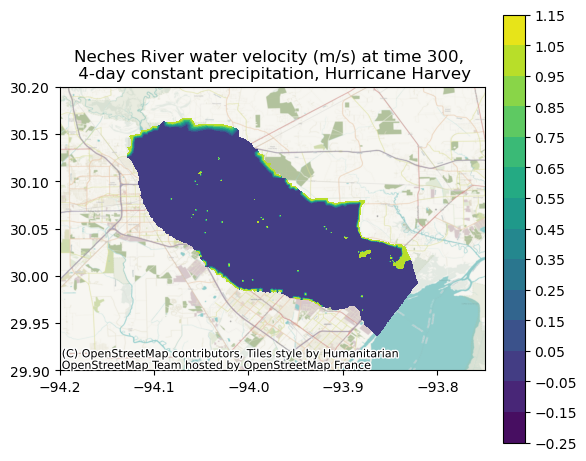

In [43]:
time_to_plot = 300
array_zeta = np.array(nc3['stag-water'][time_to_plot])
#array_zeta = np.array(nc2['v-vel'][time_to_plot])
#array_zeta_1 = np.ma.masked_equal(array_zeta, -99999.0)
zeta_min = 0#np.min(array_zeta_1)

zeta_max = 1#np.max(array_zeta)
# print(zeta_min)
# print(zeta_max)
bin_value = np.minimum((zeta_max-zeta_min)/10,1.0)
# print(bin_value)#

fig, ax = plt.subplots(figsize = (6, 6))
ax.set_xlim([-94.2, -93.75])
ax.set_ylim([29.9, 30.20])
tri = mpl.tri.Triangulation(nc1['x'][:].data, nc1['y'][:].data, nc1['element'][:,:] - 1) #form the triangles, the same triangles as used in previous plot
contours2 = ax.tricontourf(tri, array_zeta, levels = np.arange(zeta_min-0.25, zeta_max+0.25, bin_value), cmap = 'viridis',cbar = True)

ax.set_title('Neches River water velocity (m/s) at time %i, \n 4-day constant precipitation, Hurricane Harvey'%time_to_plot)
fig.colorbar(contours2, extend = 'both', ax = ax, fraction=0.046, pad=0.04, ticks=np.arange(zeta_min-0.25, zeta_max+0.25, bin_value))
cx.add_basemap(ax, crs='epsg:4326',zoom=13)

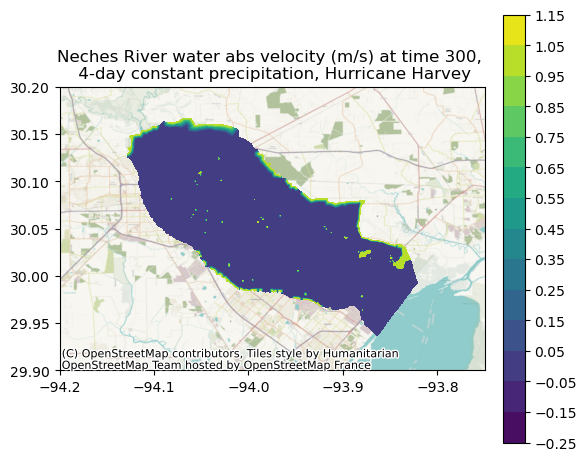

In [30]:
time_to_plot = 300
array_zeta_u = np.array(nc2['u-vel'][time_to_plot])
array_zeta_v = np.array(nc2['v-vel'][time_to_plot])
array_zeta = np.sqrt(array_zeta_u**2 + array_zeta_v**2)
array_zeta =  np.where(array_zeta<=0.001 , 1, 0)

zeta_min = 0

zeta_max = 1
# print(zeta_min)
# print(zeta_max)
bin_value = np.minimum((zeta_max-zeta_min)/10,1.0)
# print(bin_value)

fig, ax = plt.subplots(figsize = (6, 6))
ax.set_xlim([-94.2, -93.75])
ax.set_ylim([29.9, 30.20])
tri = mpl.tri.Triangulation(nc1['x'][:].data, nc1['y'][:].data, nc1['element'][:,:] - 1) #form the triangles, the same triangles as used in previous plot
contours2 = ax.tricontourf(tri, array_zeta, levels = np.arange(zeta_min-0.25, zeta_max+0.25, bin_value), cmap = 'viridis',cbar = True)

ax.set_title('Neches River water abs velocity (m/s) at time %i, \n 4-day constant precipitation, Hurricane Harvey'%time_to_plot)
fig.colorbar(contours2, extend = 'both', ax = ax, fraction=0.046, pad=0.04, ticks=np.arange(zeta_min-0.25, zeta_max+0.25, bin_value))
cx.add_basemap(ax, crs='epsg:4326',zoom=13)